<a href="https://colab.research.google.com/github/thegith45/Decentralized-learning/blob/main/fedAvg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import random


In [2]:
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return trainset, testset


In [3]:
def iid_partition_with_val(dataset, num_clients, val_ratio=0.1):
    data_size = len(dataset) // num_clients
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    client_train_idxs = []
    client_val_idxs = []

    for i in range(num_clients):
        client_data = indices[i * data_size : (i + 1) * data_size]
        val_len = int(len(client_data) * val_ratio)
        val_idx = client_data[:val_len]
        train_idx = client_data[val_len:]
        client_train_idxs.append(train_idx)
        client_val_idxs.append(val_idx)

    return client_train_idxs, client_val_idxs


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.network(x)


In [5]:
class Client:
    def __init__(self, model, dataset, train_indices, val_indices, device):
        self.device = device
        self.model = CNN().to(device)
        self.model.load_state_dict(model.state_dict())
        self.train_loader = DataLoader(Subset(dataset, train_indices), batch_size=32, shuffle=True)
        self.val_loader = DataLoader(Subset(dataset, val_indices), batch_size=64, shuffle=False)

    def train(self, epochs, lr):
        optimizer = optim.SGD(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        self.model.train()
        for _ in range(epochs):
            for data, target in self.train_loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        return self.model.state_dict()

    def validate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        return 100.0 * correct / total


In [6]:
def federated_average(models):
    avg_model = models[0].copy()
    for key in avg_model:
        for i in range(1, len(models)):
            avg_model[key] += models[i][key]
        avg_model[key] = torch.div(avg_model[key], len(models))
    return avg_model


In [7]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return 100.0 * correct / total


In [8]:
def federated_training(num_clients=10, rounds=20, frac=0.5, local_epochs=1, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model = CNN().to(device)
    trainset, testset = load_mnist()
    client_train_idxs, client_val_idxs = iid_partition_with_val(trainset, num_clients)
    test_loader = DataLoader(testset, batch_size=128, shuffle=False)

    val_accuracies = []
    test_accuracies = []

    for r in range(rounds):
        selected_clients = np.random.choice(num_clients, int(num_clients * frac), replace=False)
        local_models = []
        local_val_scores = []

        for i in selected_clients:
            client = Client(global_model, trainset, client_train_idxs[i], client_val_idxs[i], device)
            local_weights = client.train(local_epochs, lr)
            local_models.append(local_weights)
            local_val_scores.append(client.validate())

        averaged_weights = federated_average(local_models)
        global_model.load_state_dict(averaged_weights)

        val_acc = np.mean(local_val_scores)
        test_acc = evaluate(global_model, test_loader, device)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        print(f"Round {r+1} | Validation Accuracy: {val_acc:.2f}% | Test Accuracy: {test_acc:.2f}%")

    return global_model, val_accuracies, test_accuracies


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.27MB/s]


Round 1 | Validation Accuracy: 85.60% | Test Accuracy: 91.23%
Round 2 | Validation Accuracy: 93.23% | Test Accuracy: 94.42%
Round 3 | Validation Accuracy: 95.50% | Test Accuracy: 96.30%
Round 4 | Validation Accuracy: 95.60% | Test Accuracy: 96.98%
Round 5 | Validation Accuracy: 96.40% | Test Accuracy: 97.58%
Round 6 | Validation Accuracy: 97.23% | Test Accuracy: 97.95%
Round 7 | Validation Accuracy: 97.33% | Test Accuracy: 97.98%
Round 8 | Validation Accuracy: 97.43% | Test Accuracy: 98.18%
Round 9 | Validation Accuracy: 97.30% | Test Accuracy: 98.21%
Round 10 | Validation Accuracy: 97.93% | Test Accuracy: 98.39%
Round 11 | Validation Accuracy: 97.53% | Test Accuracy: 98.31%
Round 12 | Validation Accuracy: 98.00% | Test Accuracy: 98.49%
Round 13 | Validation Accuracy: 97.93% | Test Accuracy: 98.56%
Round 14 | Validation Accuracy: 98.23% | Test Accuracy: 98.59%
Round 15 | Validation Accuracy: 98.03% | Test Accuracy: 98.61%
Round 16 | Validation Accuracy: 97.70% | Test Accuracy: 98.66%
R

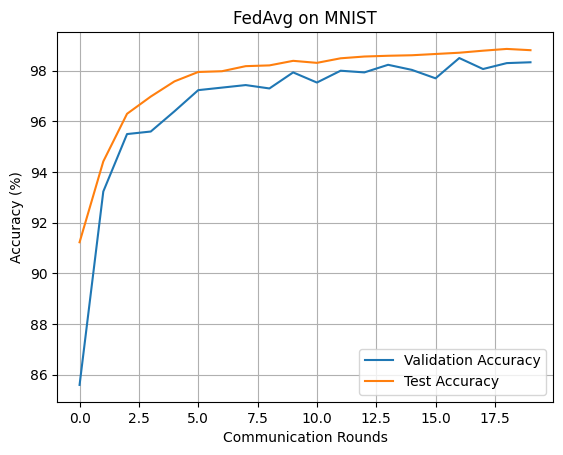

In [9]:
import matplotlib.pyplot as plt


model, val_accs, test_accs = federated_training(
    num_clients=10,
    rounds=20,
    frac=0.5,
    local_epochs=5,
    lr=0.01
)

# Plot
plt.plot(val_accs, label='Validation Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedAvg on MNIST')
plt.legend()
plt.grid()
plt.show()
